# Bring Packages

In [140]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Load Data

In [141]:

# Load training data
print("Loading training data...")
X_train = np.load("D:/GitHub/Classer-le-text---Text-classification/Data/data_train.npy").astype(int)
print("Training data loaded.")

print("Loading training labels...")
y_train_raw = np.loadtxt('D:/GitHub/Classer-le-text---Text-classification/Data/label_train.csv', skiprows=1, delimiter=',').astype(int)
print("Training labels loaded.")

print("Loading test data...")
X_test = np.load("D:/GitHub/Classer-le-text---Text-classification/Data/data_test.npy").astype(int)
print("Test data loaded.")

print("Loading vocabulary...")
vocab_data = np.load("D:/GitHub/Classer-le-text---Text-classification/Data/vocab_map.npy", allow_pickle=True)
print("Vocab data loaded.")

# Check dimensions
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train_raw.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Vocab data shape: {vocab_data.shape}")



Loading training data...
Training data loaded.
Loading training labels...
Training labels loaded.
Loading test data...
Test data loaded.
Loading vocabulary...
Vocab data loaded.
Training data shape: (9422, 26354)
Training labels shape: (9422, 2)
Test data shape: (2356, 26354)
Vocab data shape: (26354,)


In [142]:
# Separate features and labels
x_raw = X_train
y_raw = y_train_raw[:, 1]  # Use the second column as the class labels

In [143]:

print(y_raw)

[0 0 0 ... 0 0 0]


In [144]:
def testdf(df):
    if isinstance(df, pd.DataFrame):
        print("The object is a DataFrame.")
    else:
        print("The object is not a DataFrame.")

def test_if_list(obj):
    if isinstance(obj, list):
        print("The object is a list.")
    else:
        print("The object is not a list.")

def test_if_tuple(obj):
    if isinstance(obj, tuple):
        print("The object is a tuple.")
    else:
        print("The object is not a tuple.")

def test_if_array(obj):
    if isinstance(obj, np.ndarray):
        print("The object is a numpy array.")
    else:
        print("The object is not a numpy array.")

# Data Visualization

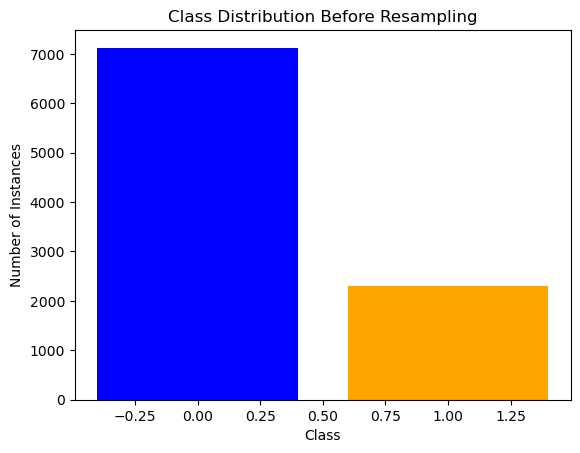

Class 0: 7124 samples
Class 1: 2298 samples


In [145]:
# Plot class distribution
unique, counts = np.unique(y_raw, return_counts=True)
plt.bar(unique, counts, color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.title("Class Distribution Before Resampling")
plt.show()

# Count the number of instances in each class
class_0_count, class_1_count = np.bincount(y_raw)

print(f"Class 0: {class_0_count} samples")
print(f"Class 1: {class_1_count} samples")


## See on average how often does a word appear in text

In [146]:
## See on average how often does a word appear in text

In [147]:
ind_class0 = (y_raw==1).nonzero()[0]
print(ind_class0)
ind_class1 = (y_raw==0).nonzero()[0]
print(ind_class1)

[   4    8    9 ... 9410 9412 9418]
[   0    1    2 ... 9419 9420 9421]


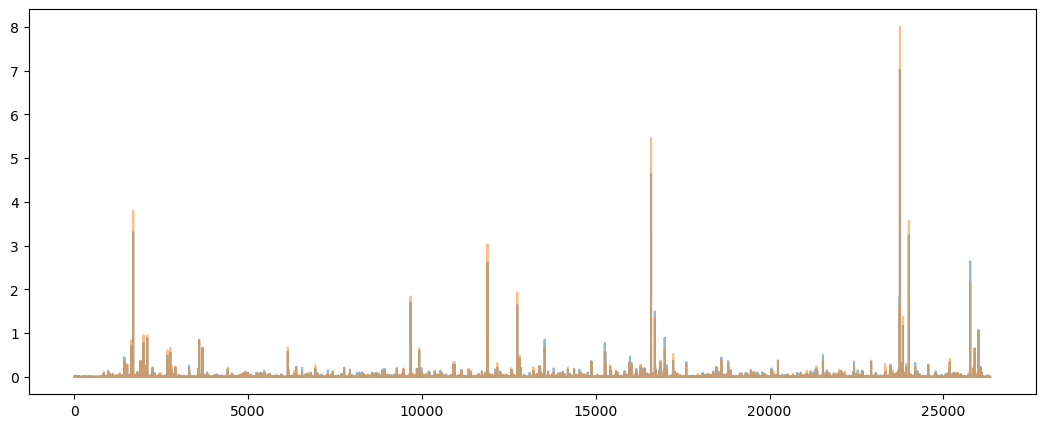

In [148]:
plt.figure(figsize=(13,5))
plt.plot(X_train[ind_class0,:].mean(axis=0),alpha=0.5)
plt.plot(X_train[ind_class1,:].mean(axis=0),alpha=0.5)
# plt.semilogy()
# plt.ylim(0.1,2)

In [149]:
# Calculate the mean appearance of each word for each class
mean_appearance_class_0 = x_raw[y_raw == 0].mean(axis=0)
mean_appearance_class_1 = x_raw[y_raw == 1].mean(axis=0)

# Compute the absolute difference in mean appearance between the two classes
mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)

# Identify the words with the largest differences
largest_diff_indices = np.argsort(mean_difference)[::-1]  # Sort indices in descending order of difference

top_n = 30  # Number of top words to display
top_words = [vocab_data[i] for i in largest_diff_indices[:top_n]]
print(top_words)


['the', 'of', 'and', 'we', 'in', 'to', 'is', 'our', 'that', 'models', 'this', 'model', 'learning', 'neural', 'system', 'are', 'on', 'paper', 'show', 'for', 'based', 'used', 'systems', 'an', 'art', 'be', 'matrix', 'convex', 'information', 'tasks']


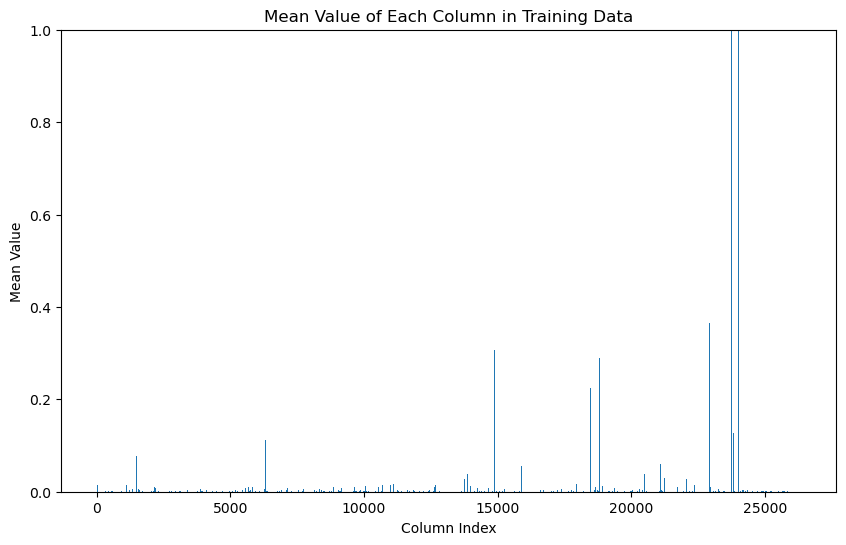

In [150]:
column_means = np.mean(x_raw, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [151]:
column_means

array([0.00021227, 0.00870304, 0.00010613, ..., 0.00021227, 0.00021227,
       0.00159202])

In [152]:
## Removal 

In [153]:
# Compute the ANOVA F-value for the provided sample
F_values, p_values = f_classif(x_raw, y_raw)

# Print the F-values and p-values
print("F-values:", F_values)
print("p-values:", p_values)

# Select features with high F-values (low p-values)
significant_features = np.where(p_values < 0.05)[0]
print("Significant feature indices:", significant_features)
len(significant_features)

F-values: [0.711383   1.3251327  0.32254848 ... 0.32254848 0.32254848 0.7186723 ]
p-values: [0.3990065  0.24970217 0.57009363 ... 0.57009363 0.57009363 0.39660132]
Significant feature indices: [  150   227   272 ... 26269 26270 26325]


1907

## Stop words removal

In [154]:
# Define a list of stop words
stop_words = ['a', 'an', 'the', 'and', 'or', 'but', 'if', 'while', 'with', 'without', 'of', 'at', 'by', 'for', 'to', 'in', 'on', 'from', 'up', 'down', 'out', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

# Identify the indices of the stop words in the vocabulary
stop_word_indices = [i for i, word in enumerate(vocab_data) if word in stop_words]

print(stop_word_indices)

[1293, 1466, 1634, 1691, 1811, 2246, 3299, 3571, 3590, 3686, 7452, 7487, 7761, 9341, 9674, 9921, 10008, 11072, 11341, 11639, 11884, 13002, 15415, 15442, 16141, 16262, 16291, 16335, 16591, 16701, 16703, 16717, 16865, 16972, 16991, 17049, 17136, 20791, 21536, 21929, 22003, 22924, 23744, 23753, 23774, 23796, 24009, 24051, 24780, 25114, 25415, 25891, 25894, 25911, 25926, 25974, 26016, 26021]


## Feature Selection

In [155]:
# Flatten the lists if they are not already 1D
stop_word_indices_flat = np.array(stop_word_indices).flatten()
significant_features_flat = np.array(significant_features).flatten()

# Merge the two lists and remove duplicates by converting to a set and back to a list
merged_indices = list(set(stop_word_indices_flat.tolist() + significant_features_flat.tolist()))

print("Merged indices count:", len(merged_indices))

Merged indices: [8199, 24583, 8201, 8203, 24590, 16401, 16417, 24615, 24622, 24624, 24635, 8254, 8255, 8256, 24638, 8268, 8270, 8281, 16478, 8304, 16501, 16508, 16522, 8331, 16524, 8333, 8334, 8335, 16527, 8340, 150, 8342, 16535, 24727, 24729, 24732, 24733, 24734, 8351, 16551, 24745, 16557, 24761, 8380, 24780, 8397, 16591, 16603, 227, 24803, 8426, 24822, 8446, 8447, 8449, 16647, 272, 24849, 278, 282, 16669, 16676, 8486, 8487, 8498, 16690, 16701, 16703, 16708, 24902, 8520, 16717, 341, 8533, 16726, 8536, 16728, 16729, 16730, 24922, 16733, 24930, 24939, 8556, 16750, 8565, 24949, 24954, 24958, 387, 24964, 392, 24971, 16785, 16786, 8595, 16789, 8605, 24989, 16800, 8610, 16802, 16809, 8620, 8622, 8623, 8624, 8626, 8627, 25013, 8631, 8634, 25018, 16829, 16830, 449, 453, 16837, 16838, 16843, 16844, 16845, 16850, 25042, 471, 16856, 8667, 8670, 16865, 16866, 16867, 8684, 8685, 8695, 504, 16890, 515, 8707, 524, 16910, 16912, 16914, 8724, 25114, 16923, 8733, 8735, 8740, 8742, 25133, 16944, 8763, 8

In [156]:
x_raw_filtered = np.delete(x_raw, merged_indices, axis=1)

X_test_filtered = np.delete(X_test, merged_indices, axis=1)

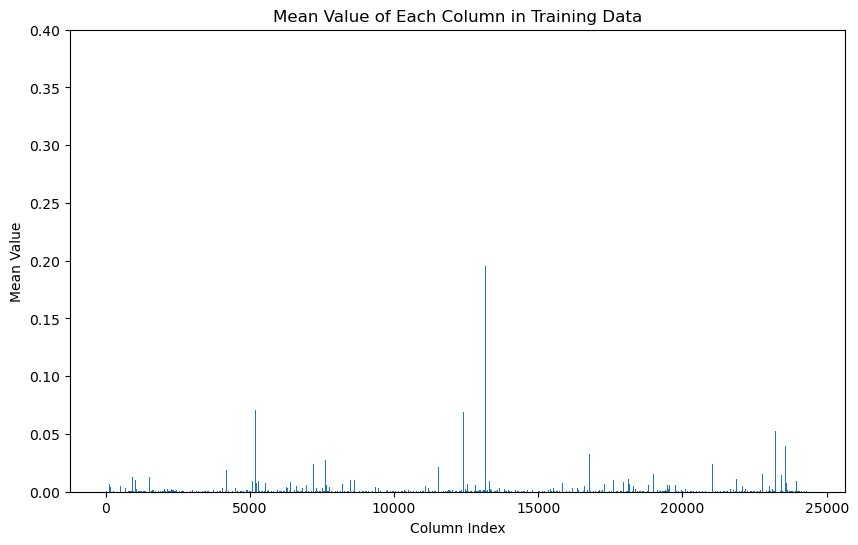

In [157]:
column_means = np.mean(x_raw_filtered, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 0.4)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

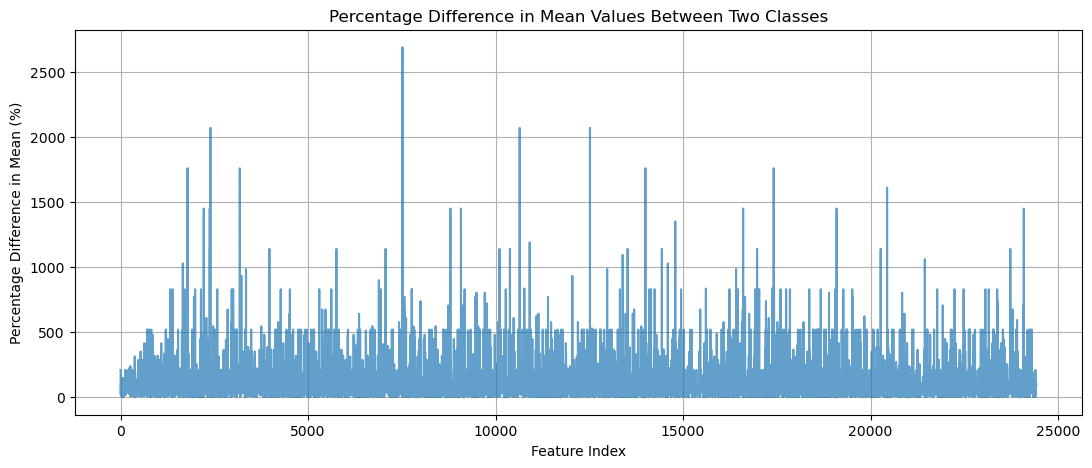

In [158]:
# Calculate the mean values for each class
mean_class0 = x_raw_filtered[ind_class0, :].mean(axis=0)
mean_class1 = x_raw_filtered[ind_class1, :].mean(axis=0)

# Calculate the percentage difference in means
percentage_difference = np.zeros_like(mean_class0)
for i in range(len(mean_class0)):
    if mean_class0[i] != 0 and mean_class1[i] != 0:
        percentage_difference[i] = 100 * abs(mean_class1[i] - mean_class0[i]) / min(mean_class0[i], mean_class1[i])
    elif mean_class0[i] != 0:
        percentage_difference[i] = 100 * abs(mean_class1[i] - mean_class0[i]) / mean_class0[i]
    elif mean_class1[i] != 0:
        percentage_difference[i] = 100 * abs(mean_class1[i] - mean_class0[i]) / mean_class1[i]
    else:
        percentage_difference[i] = 0 

# Plot the percentage difference in means
plt.figure(figsize=(13, 5))
plt.plot(percentage_difference, alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Percentage Difference in Mean (%)')
plt.title('Percentage Difference in Mean Values Between Two Classes')
plt.grid(True)
plt.show()

## Data manipulation and feature engineering

In [159]:
x_train_start = x_raw_filtered
x_test_start = X_test_filtered

print(x_train_start.shape)
print(x_test_start.shape)

(9422, 24423)
(2356, 24423)


### Handling Class Imbalance

 #### Oversampling the Minority Class

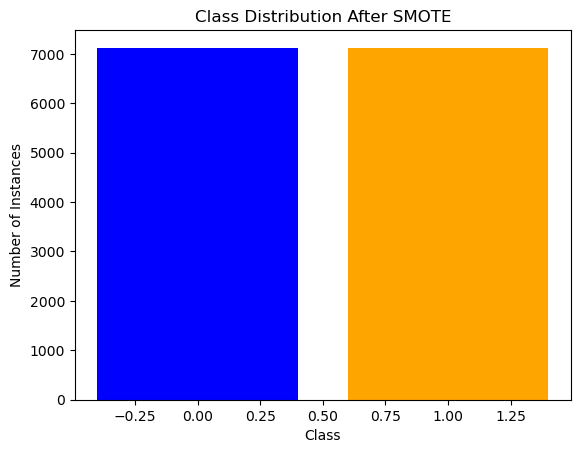

In [160]:
# Convert to DataFrame for SMOTE
data_balanced = pd.DataFrame(csr_matrix(x_train_start).todense())
data_balanced['label'] = y_raw

# Separate features and labels
X = data_balanced.drop('label', axis=1)
y = data_balanced['label']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_balanced, y_balanced = smote.fit_resample(X, y)

# Plot the new class distribution
unique_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
plt.bar(unique_balanced, counts_balanced, color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.title("Class Distribution After SMOTE")
plt.show()

In [161]:
x_balanced.shape

(14248, 24423)

### Handling Sparsity and Scaling

In [162]:

# Convert x_balanced to sparse matrix for efficiency
x_balanced_sparse = csr_matrix(x_balanced)

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler(with_mean=False)  # with_mean=False due to sparse matrix
x_balanced_scaled = scaler.fit_transform(x_balanced_sparse)

## Model Training

## Logistic regression


In [163]:
x_train_final = x_balanced_scaled
y_train_final = y_balanced

In [164]:
# Create a stratified train-validation split to maintain class distribution across sets
X_train, X_val, y_train, y_val = train_test_split(x_train_final, y_train_final, test_size=0.2, stratify=y_balanced, random_state=42)

# Initialize logistic regression with balanced class weights
model = LogisticRegression(class_weight="balanced", max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Calculate F1 score
f1 = f1_score(y_val, y_pred)

print(f"Validation F1 Score: {f1}")

accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy: {accuracy}")

Validation F1 Score: 0.7576348278102664
Test Accuracy: 0.7382456140350877


## Cross-Validation

In [165]:
# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5)
cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")

print(f"Cross-validated F1 Scores: {cv_f1_scores}")
print(f"Mean CV F1 Score: {np.mean(cv_f1_scores)}")

Cross-validated F1 Scores: [0.76120016 0.76182708 0.76434676 0.76264912 0.74023359]
Mean CV F1 Score: 0.7580513425358029


## Threshold Tuning 

In [166]:
# Get predicted probabilities
y_proba = model.predict_proba(X_val)[:, 1]

# Search for the best threshold for maximum F1 score
best_f1, best_threshold = 0, 0.5
for threshold in np.arange(0.1, 0.9, 0.05):
    y_pred_threshold = (y_proba >= threshold).astype(int)
    f1_temp = f1_score(y_val, y_pred_threshold)
    if f1_temp > best_f1:
        best_f1, best_threshold = f1_temp, threshold

print(f"Best F1 Score: {best_f1} at Threshold: {best_threshold}")




Best F1 Score: 0.7646276595744681 at Threshold: 0.7000000000000002


In [167]:
# Final predictions using the optimal threshold
y_final_pred = (y_proba >= best_threshold).astype(int)

# Final F1 score with optimized threshold
final_f1 = f1_score(y_val, y_final_pred)
print(f"Final F1 Score with Optimized Threshold: {final_f1}")

Final F1 Score with Optimized Threshold: 0.7646276595744681


# Train a Random Forest Classifier

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report

In [169]:
# Initialize the Random Forest Classifier with class_weight='balanced' to handle class imbalance
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

In [170]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],         # Number of trees in the forest
    'max_depth': [10, 20, None],        # Maximum depth of the tree
    'min_samples_split': [2, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 5]          # Minimum number of samples required to be at a leaf node
}

# Use GridSearchCV to find the best hyperparameters for Random Forest
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(x_balanced_scaled, y_balanced)

# Best model from grid search
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Evaluate Model on Validation Data

In [171]:
# Predict on the validation set
y_val_pred_rf = best_rf_model.predict(X_val)

# Calculate F1 score on validation set
f1_rf = f1_score(y_val, y_val_pred_rf)
print(f"Validation F1 Score with Random Forest: {f1_rf}")

# Print classification report for detailed evaluation
print("Classification Report on Validation Data:")
print(classification_report(y_val, y_val_pred_rf))

Validation F1 Score with Random Forest: 1.0
Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1425
           1       1.00      1.00      1.00      1425

    accuracy                           1.00      2850
   macro avg       1.00      1.00      1.00      2850
weighted avg       1.00      1.00      1.00      2850



### Cross Validation

In [172]:
# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5)
cv_f1_scores = cross_val_score(best_rf_model, X_train, y_train, cv=cv, scoring="f1")

print(f"Cross-validated F1 Scores: {cv_f1_scores}")
print(f"Mean CV F1 Score: {np.mean(cv_f1_scores)}")

Cross-validated F1 Scores: [0.77000457 0.77328487 0.77993674 0.77375566 0.74658159]
Mean CV F1 Score: 0.7687126845400397


## Generate predicted x_test

### Preparing x_test

In [173]:
# Convert `X_test` to sparse format for efficient processing
X_test_sparse = csr_matrix(x_test_start)

# Standardize `X_test` using the scaler fitted on `X_train`
X_test_scaled = scaler.transform(X_test_sparse)

### Predicting on X_test

In [174]:

# Predict class probabilities on the test set
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

# Apply the optimized threshold (from threshold tuning) to get final predictions
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Display or save the predictions as needed.

# Print out the first few predictions for inspection
print("First 10 Test Predictions:", y_test_pred[:10])

First 10 Test Predictions: [1 0 0 0 0 0 1 1 0 0]


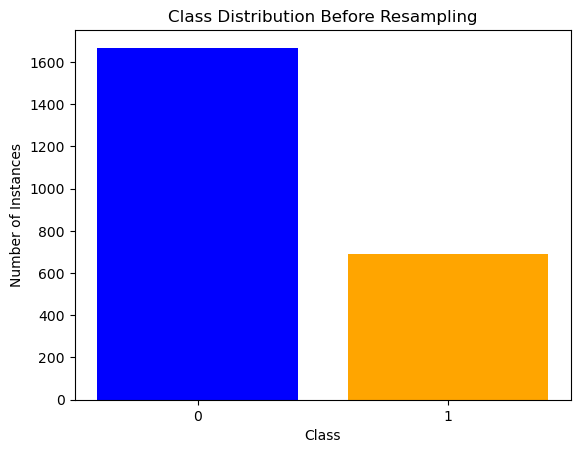

Class 0: 1667 samples
Class 1: 689 samples
0.4133173365326935


In [175]:
# Plot class distribution
unique, counts = np.unique(y_test_pred, return_counts=True)
plt.bar(unique, counts, color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.title("Class Distribution Before Resampling")
plt.xticks([0, 1])
plt.show()

# Count the number of instances in each class
class_0_count, class_1_count = np.bincount(y_test_pred)

print(f"Class 0: {class_0_count} samples")
print(f"Class 1: {class_1_count} samples")
print(class_1_count/class_0_count)

In [176]:


# Predict class probabilities on the test set
y_test_pred_rf = best_rf_model.predict(X_test_scaled)

# Apply the optimized threshold (from threshold tuning) to get final predictions
print(y_test_pred_rf.shape)

# Display or save the predictions as needed.


# Print out the first few predictions for inspection
print("First 10 Test Predictions:", y_test_pred_rf[:10])
print("Unique predictions:", np.unique(y_test_pred_rf))


(2356,)
First 10 Test Predictions: [0 0 0 0 0 0 0 0 0 0]
Unique predictions: [0 1]


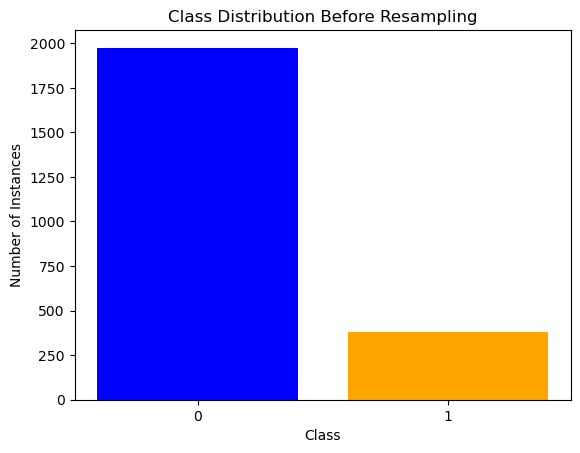

Class 0: 1975 samples
Class 1: 381 samples
0.1929113924050633


In [182]:
# Plot class distribution
unique, counts = np.unique(y_test_pred_rf, return_counts=True)
plt.bar(unique, counts, color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.title("Class Distribution Before Resampling")
plt.xticks([0, 1])
plt.show()

# Count the number of instances in each class
class_0_count, class_1_count = np.bincount(y_test_pred_rf)

print(f"Class 0: {class_0_count} samples")
print(f"Class 1: {class_1_count} samples")
print(class_1_count/class_0_count)

# Download results

In [178]:
import pandas as pd
import os as os

In [179]:
def save_array_with_index(array, filename):
    # Create a DataFrame with the array
    df = pd.DataFrame(array, columns=['label'])
    
    # Add the 'id' column using the row index
    df['ID'] = df.index
    
    # Reorder the columns to have 'id' first and 'label' second
    df = df[['ID', 'label']]
    
    # Check if the file exists and save over it
    if os.path.exists(filename):
        print(f"File {filename} exists. Saving over it.")
    else:
        print(f"File {filename} does not exist. Creating a new file.")
    
    # Save the DataFrame as a CSV file
    print("Saving")
    df.to_csv(filename, index=False)
    print("Saved")

In [180]:
filename = 'prediction_milestone2.csv'

#save_array_with_index(y_test_pred, filename)

In [181]:
filename = 'prediction_milestone2_rf.csv'

#save_array_with_index(y_test_pred_rf, filename)